In [1]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from src.comb import incremental_levels
from src.data import get_real_samples
from src.dataset import process_dataset

sns.set_context('notebook')
sns.set_style('whitegrid')

NUM_LAYERS = 3
NUM_UNITS = [8, 16, 32]
EPOCHS = 1000

Covasim 2.0.3 (2021-03-11) — © 2021 by IDM


# Surrogate Model

## Load Dataset

We start by retrieving the data obtained from *Covasim*.

Each row describes the evolution of the pandemic via hospitalized, diagnosed, and dead people curves for a time interval of 42 days, the first half of which relative to the *initial zone* while the second half relative to the *actuated zone*.

> Both the initial and the actuated zone can be either *white* (`W`), *yellow* (`Y`), *orange* (`O`), or *red* (`R`).

In [2]:
df = pd.read_csv('../res/dataset.csv')
df

,hosp_0,diag_0,dead_0,hosp_1,diag_1,dead_1,hosp_2,diag_2,dead_2,hosp_3,...,diag_39,dead_39,hosp_40,diag_40,dead_40,hosp_41,diag_41,dead_41,init_zone,actuated_zone
0,98.0,49.0,1.0,106.0,118.0,1.0,107.0,89.0,3.0,116.0,...,44.0,5.0,143.0,36.0,2.0,135.0,19.0,1.0,Y,R
1,224.0,95.0,1.0,219.0,135.0,7.0,223.0,128.0,4.0,227.0,...,59.0,0.0,78.0,28.0,1.0,83.0,81.0,1.0,R,W
2,119.0,22.0,3.0,109.0,17.0,2.0,100.0,23.0,1.0,91.0,...,129.0,3.0,199.0,146.0,2.0,196.0,112.0,6.0,W,Y
3,94.0,50.0,0.0,96.0,99.0,2.0,106.0,100.0,0.0,111.0,...,27.0,3.0,144.0,21.0,1.0,138.0,15.0,5.0,Y,R
4,193.0,65.0,6.0,198.0,170.0,2.0,199.0,145.0,5.0,206.0,...,36.0,1.0,35.0,28.0,2.0,36.0,33.0,1.0,R,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,128.0,17.0,5.0,121.0,23.0,2.0,104.0,14.0,4.0,89.0,...,7.0,0.0,9.0,7.0,0.0,10.0,14.0,0.0,R,O
1396,15.0,2.0,0.0,14.0,1.0,0.0,13.0,1.0,0.0,11.0,...,3.0,0.0,18.0,1.0,0.0,13.0,0.0,1.0,O,R
1397,10.0,7.0,0.0,13.0,16.0,0.0,16.0,12.0,0.0,16.0,...,17.0,0.0,15.0,11.0,0.0,14.0,13.0,1.0,R,W
1398,11.0,1.0,1.0,6.0,2.0,1.0,5.0,2.0,0.0,4.0,...,14.0,1.0,46.0,21.0,2.0,36.0,9.0,5.0,W,O


## Data Preprocessing

On the one hand, we will use the first 21 days as input data together with the initial and the actuated zone. In order to have more robustness and avoid the weekly oscillations, we apply a *7-days moving average* on the numeric data, while *one-hot encoding* the two categorical features, namely the two zones. This results in an input vector of $(21 - 7 + 1) * 3 + 4 * 2 = 53$ features.

On the other hand, we use the second half of the data in order to get the *hospitalized peak*, the *cumulative deaths*, and the *cumulative diagnoses* in the following three weeks. These three features will be used as target for the network.

Then, we *standardize* the input vector (except for the eight binary features) and *normalize* the output data.

Finally, we split between a *training* and a *validation* set, being respectively 80% and 20% of the whole data.

In [3]:
(xtr, ytr), (xvl, yvl), _ = process_dataset(df, val_split=0.2, scale_data=True)
print(f'x train: {xtr.shape}, x val: {xvl.shape}')
print(f'y train: {ytr.shape}, y val: {yvl.shape}')

x train: (1120, 53), x val: (280, 53)
y train: (1120, 3), y val: (280, 3)


## Hyperparameters Tuning

We are now ready to define the structure of our neural model.

We use Keras `Sequential` API with `Dense` layers only in order to be able to port the model into the *Empirical Model Learning* library. Then, we train different model configurations, changing both the number of layers (*0* to *3*) and the number of hidden units (*8*, *16*, or *32*) for each layer, for a total of $1 + 3 + 3^2 + 3^3 = 40$ configurations.

In [4]:
scores = {}
configurations = incremental_levels(num_levels=NUM_LAYERS, parameters=NUM_UNITS)

for idx, config in enumerate(configurations):
    print(f'Model {idx + 1:0{len(str(len(configurations)))}}/{len(configurations)}', end='')
    start_time = time.time()
    early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
    model = Sequential([Dense(hu, activation='relu') for hu in config] + [Dense(3)])
    model.compile(optimizer='adam', loss='mse')
    model.fit(xtr, ytr, validation_split=0.2, epochs=EPOCHS, callbacks=[early_stopping], verbose=False)
    ptr, pvl = model.predict(xtr), model.predict(xvl)
    config = config + (0,) * NUM_LAYERS
    config = config[:NUM_LAYERS]
    scores[(0,) if config == () else config] = {
        'train_mse': mean_squared_error(ytr, ptr),
        'train_r2': r2_score(ytr, ptr),
        'val_mse': mean_squared_error(yvl, pvl),
        'val_r2': r2_score(yvl, pvl)
    }
    print(f' -- elapsed time: {time.time() - start_time:.4}s')

Model 01/40 -- elapsed time: 39.67s
Model 02/40 -- elapsed time: 57.77s
Model 03/40 -- elapsed time: 49.95s
Model 04/40 -- elapsed time: 34.55s
Model 05/40 -- elapsed time: 43.13s
Model 06/40 -- elapsed time: 34.9s
Model 07/40 -- elapsed time: 35.85s
Model 08/40 -- elapsed time: 43.89s
Model 09/40 -- elapsed time: 43.54s
Model 10/40 -- elapsed time: 35.04s
Model 11/40 -- elapsed time: 30.06s
Model 12/40 -- elapsed time: 31.7s
Model 13/40 -- elapsed time: 31.89s
Model 14/40 -- elapsed time: 60.09s
Model 15/40 -- elapsed time: 31.68s
Model 16/40 -- elapsed time: 23.92s
Model 17/40 -- elapsed time: 39.66s
Model 18/40 -- elapsed time: 37.71s
Model 19/40 -- elapsed time: 29.97s
Model 20/40 -- elapsed time: 32.29s
Model 21/40 -- elapsed time: 35.49s
Model 22/40 -- elapsed time: 18.18s
Model 23/40 -- elapsed time: 40.8s
Model 24/40 -- elapsed time: 37.49s
Model 25/40 -- elapsed time: 39.02s
Model 26/40 -- elapsed time: 26.59s
Model 27/40 -- elapsed time: 45.28s
Model 28/40 -- elapsed time: 31

Once all the models have been trained, we collect their scores on both the training and validation data, then we get the best configuration, namely the one with higher *validation r2*.

In [5]:
results = pd.DataFrame.from_dict(scores, orient='index').sort_values('val_r2', ascending=False)
results

train_mse  train_r2   val_mse    val_r2
8  16 16   0.000271  0.987574  0.000516  0.979116
   8  8    0.000287  0.986883  0.000519  0.978967
16 0  0    0.000282  0.987095  0.000539  0.978167
8  32 0    0.000280  0.987181  0.000554  0.977551
16 16 0    0.000242  0.988935  0.000566  0.977125
   32 0    0.000265  0.987814  0.000567  0.977049
8  8  0    0.000322  0.985270  0.000575  0.976705
   32 8    0.000350  0.983968  0.000580  0.976504
   0  0    0.000366  0.983268  0.000585  0.976307
32 8  16   0.000281  0.987108  0.000602  0.975638
   0  0    0.000304  0.986127  0.000610  0.975354
8  16 8    0.000321  0.985318  0.000614  0.975181
   8  16   0.000328  0.985003  0.000615  0.975089
32 8  8    0.000254  0.988351  0.000640  0.974126
8  32 16   0.000267  0.987783  0.000648  0.973784
32 16 0    0.000243  0.988866  0.000653  0.973581
16 8  32   0.000261  0.988026  0.000654  0.973546
32 16 32   0.000223  0.989777  0.000657  0.973415
   32 0    0.000217  0.990064  0.000660  0.973308
16 16 16   0.000196  0.990999  0.000662  0.973199
      8    0.000297  0.986364  0.000662  0.973154
8  8  32   0.000340  0.984460  0.000663  0.973144
16 8  0    0.000346  0.984162  0.000677  0.972601
      8    0.000333  0.984724  0.000678  0.972519
   32 8    0.000278  0.987271  0.000680  0.972510
   8  16   0.000309  0.985843  0.000686  0.972157
32 16 8    0.000223  0.989776  0.000690  0.972115
8  32 32   0.000383  0.982462  0.000693  0.971919
32 32 16   0.000241  0.988945  0.000704  0.971422
   8  32   0.000267  0.987820  0.000713  0.971147
8  16 32   0.000321  0.985323  0.000717  0.970984
32 16 16   0.000282  0.987105  0.000717  0.970924
8  16 0    0.000377  0.982727  0.000734  0.970265
16 32 32   0.000266  0.987857  0.000765  0.969046
      16   0.000227  0.989579  0.000767  0.968985
32 32 8    0.000220  0.989923  0.000805  0.967402
16 16 32   0.000248  0.988639  0.000811  0.967226
32 8  0    0.000397  0.981780  0.000846  0.965683
   32 32   0.000202  0.990746  0.000890  0.964044
0  0  0    0.001058  0.952020  0.001361  0.945187

# Final Model

## Training

Now that we have selected the best parameters' configuration, we can train the model again on the whole data.

> A validation split of *0.2* is still kept for the `EarlyStopping` callback, which was in any case used in the model selection phase as well.

In [6]:
best_config = results.index[0]
(x, y), (x_scaler, y_scaler) = process_dataset(df, val_split=None, scale_data=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
model = Sequential([Dense(hu, activation='relu') for hu in best_config if hu != 0] + [Dense(3)])
model.compile(optimizer='adam', loss='mse')
history = model.fit(x, y, validation_split=0.2, epochs=EPOCHS, callbacks=[early_stopping], verbose=True)

Epoch 1/1000
35/35 [==============================] - ETA: 7s - loss: 0.8916 - 0s 4ms/step - loss: 0.3503 - val_loss: 0.0238
Epoch 2/1000
35/35 [==============================] - ETA: 0s - loss: 0.0269 - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0128
Epoch 3/1000
35/35 [==============================] - ETA: 0s - loss: 0.0138 - 0s 2ms/step - loss: 0.0141 - val_loss: 0.0088
Epoch 4/1000
35/35 [==============================] - ETA: 0s - loss: 0.0075 - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0066
Epoch 5/1000
35/35 [==============================] - ETA: 0s - loss: 0.0072 - 0s 6ms/step - loss: 0.0074 - val_loss: 0.0052
Epoch 6/1000
35/35 [==============================] - ETA: 0

Here's the evolution of the training.

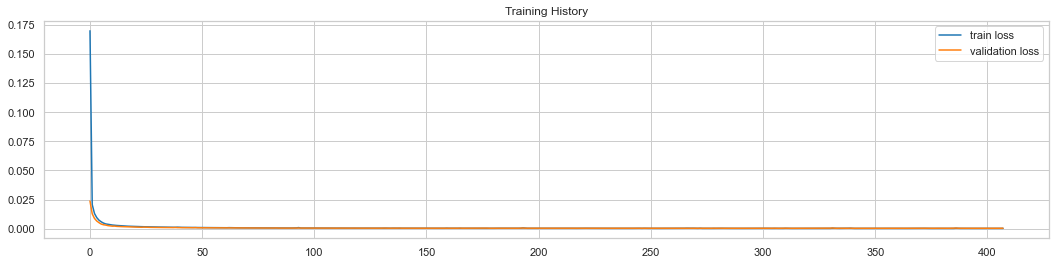

In [7]:
plt.figure(figsize=(18, 4))
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train loss').set(title='Training History')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='validation loss')
plt.show()

As we can see, the model is able to capture the trend very well about the *simulated* data.

MSE: 19501.5857, R2: 0.9849197886252982:.4f


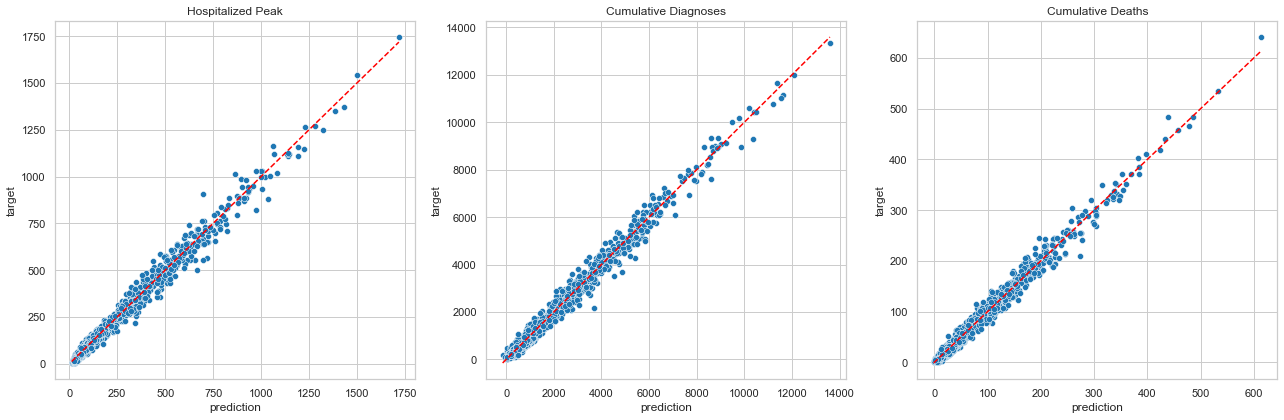

In [8]:
p = model.predict(x)
y, p = y_scaler.inverse_transform(y), y_scaler.inverse_transform(p)
print(f'MSE: {mean_squared_error(y, p):.4f}, R2: {r2_score(y, p)}:.4f')
_, axes = plt.subplots(1, 3, figsize=(18, 6), tight_layout=True)
for idx, title in enumerate(['Hospitalized Peak', 'Cumulative Diagnoses', 'Cumulative Deaths']):
    pp, yy = p[:, idx], y[:, idx]
    sns.scatterplot(x=pp, y=yy, ax=axes[idx]).set(xlabel='prediction', ylabel='target', title=title)
    axes[idx].plot([pp.min(), pp.max()], [pp.min(), pp.max()], 'r--')

## Real-Data Performances

In order to assess how good is our model with respect to the pandemic situation, we also retrieve some sample points from the *real data* regarding the Emilia-Romagna.

In [9]:
region = 'Emilia-Romagna'
zones = {
    '2020-05-18': 'W',
    '2020-11-08': 'Y',
    '2020-11-15': 'O',
    '2020-12-10': 'Y',
    '2020-12-21': 'O',
    '2021-02-01': 'Y',
    '2021-02-21': 'O',
    '2021-03-01': 'R',
    '2021-04-12': 'O',
    '2021-04-26': 'Y'
}
real_df = get_real_samples(region=region, zones=zones, scaling_factor=4.46e6 / 400e3)
real_df

,hosp_0,diag_0,dead_0,hosp_1,diag_1,dead_1,hosp_2,diag_2,dead_2,hosp_3,...,diag_39,dead_39,hosp_40,diag_40,dead_40,hosp_41,diag_41,dead_41,init_zone,actuated_zone
0,45.381166,47.174888,0.538117,49.417040,49.417040,0.269058,54.618834,45.470852,0.448430,61.165919,...,193.273543,4.932735,262.152466,194.080717,5.919283,261.704036,194.170404,6.278027,W,Y
1,75.784753,106.905830,0.358744,81.524664,102.511211,0.269058,93.004484,126.278027,1.345291,100.269058,...,157.847534,7.623318,265.919283,191.838565,5.650224,264.573991,176.143498,4.663677,Y,O
2,245.112108,193.721973,4.484305,249.147982,226.905830,4.215247,254.260090,243.946188,4.215247,261.434978,...,67.264574,2.780269,252.825112,80.000000,8.071749,257.488789,127.982063,6.188341,O,Y
3,269.417040,183.049327,3.497758,266.905830,131.659193,4.663677,263.587444,140.717489,6.188341,261.255605,...,181.524664,7.174888,261.793722,160.358744,6.188341,263.856502,196.502242,5.201794,Y,O
4,267.174888,173.991031,5.919283,266.098655,140.179372,4.573991,260.807175,105.650224,5.919283,254.977578,...,162.511211,4.125561,186.098655,153.183857,2.062780,190.403587,165.919283,3.677130,O,Y
5,207.892377,114.260090,1.973094,214.170404,94.260090,3.049327,212.914798,78.295964,6.367713,207.713004,...,253.004484,4.035874,318.116592,308.789238,3.139013,323.587444,262.242152,2.780269,Y,O
6,195.964126,114.080717,2.869955,193.094170,86.008969,4.035874,190.134529,82.600897,3.318386,186.636771,...,283.587444,3.766816,351.569507,227.623318,4.215247,355.336323,218.923767,3.049327,O,R


In [10]:
(x_test, y_test), = process_dataset(real_df, val_split=None, scale_data=False)
print(f'x test: {x_test.shape}, y test: {y_test.shape}')

x test: (7, 53), y test: (7, 3)


MSE: 635792.2130, R2: -1.2593274988068366:.4f


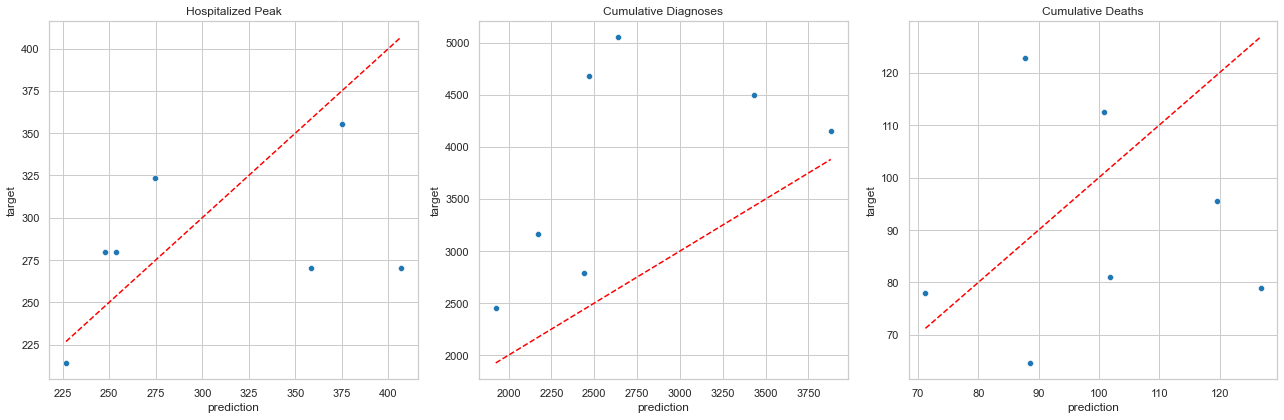

In [11]:
p_test = model.predict(x_scaler.transform(x_test))
p_test = y_scaler.inverse_transform(p_test)
print(f'MSE: {mean_squared_error(y_test, p_test):.4f}, R2: {r2_score(y_test, p_test)}:.4f')

_, axes = plt.subplots(1, 3, figsize=(18, 6), tight_layout=True)
for idx, title in enumerate(['Hospitalized Peak', 'Cumulative Diagnoses', 'Cumulative Deaths']):
    pp, yy = p_test[:, idx], y_test[:, idx]
    sns.scatterplot(x=pp, y=yy, ax=axes[idx]).set(xlabel='prediction', ylabel='target', title=title)
    axes[idx].plot([pp.min(), pp.max()], [pp.min(), pp.max()], 'r--')

In [12]:
model.save('../res/model')

INFO:tensorflow:Assets written to: ../res/model\assets
